## Monte Carlo Tests
To motivate resampling methods, suppose we wish to infer from measurements whether the weights of adult human males in a medical study are normally distributed [[1](https://www.jstor.org/stable/2333709https://www.jstor.org/stable/2333709)]. This may be prerequisite to performing other statistical tests, many of which are developed under the assumption that samples are drawn from a normally distributed population (although some tests are quite robust to deviations from this assumption, as we will see later). The weights are recorded in the array `x` below.

In [1]:
import numpy as np
x = np.array([148, 154, 158, 160, 161, 162, 166, 170, 182, 195, 236])  # weights (lbs)

One way of testing for departures from normality, chosen based on its simplicity rather than its sensitivity, is the [Jarque-Bera test [2]](https://www.sciencedirect.com/science/article/abs/pii/0165176580900245) implemented in SciPy as `scipy.stats.jarque_bera`. The test, like many other hypothesis tests, computes a *statistic* based on the sample and compares its value to the distribution of the statistic derived under the *null hypothesis* that the sample is normally distributed. If the value of the statistic is extreme compared to this *null distribution* - that is, if there is a low probability of sampling such data from a normally distributed population - then we have evidence to reject the null hypothesis.

The statistic is calculated based on the skewness and kurtosis of the sample as follows.

In [2]:
from scipy import stats

def statistic(x):
    # Calculates the Jarque-Bera Statistic
    # Compare against `scipy.stats.jarque_bera`:
    # https://github.com/scipy/scipy/blob/4cf21e753cf937d1c6c2d2a0e372fbc1dbbeea81/scipy/stats/_stats_py.py#L1583-L1637
    n = len(x)
    mu = np.mean(x, axis=0)
    x = x - mu  # remove the mean from the data
    s = stats.skew(x)  # calculate the sample skewness
    k = stats.kurtosis(x)  # calculate the sample kurtosis
    statistic = n/6 * (s**2 + k**2/4)
    return statistic

stat1 = statistic(x)
stat2, _ = stats.jarque_bera(x)
np.testing.assert_allclose(stat1, stat2, rtol=1e-14)
stat1

6.982848237344646

Note that the value of the statistic is unaffected by the scale and location of the data.

In [3]:
old_location = np.mean(x)
old_scale = np.std(x)
x_new = (x - old_location) / old_scale  # make location 0 and scale 1
stat3 = statistic(x_new)
np.testing.assert_allclose(stat1, stat3, rtol=1e-14)

Consequently, it can be shown that large samples drawn from a normal distribution with any mean and variance will produce statistic values that are distributed according to the chi-squared distribution with two degrees of freedom. We can check this numerically by drawing 1000 samples of size 500 from a standard normal distribution and computing the value of the statistic for each sample.

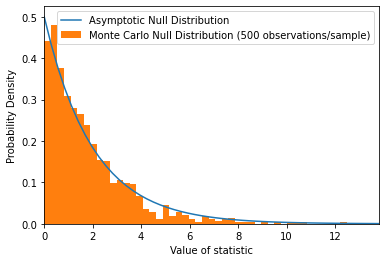

In [4]:
np.random.seed(0)
n_observations = 500  # number of observations
n_samples = 1000  # number of samples
# standard normal distribution can be used, since the
# statistic is unaffected by location and scale
norm_dist = stats.norm()
# Draw 1000 samples, each with 500 observations
y = norm_dist.rvs(size=(n_observations, n_samples))

# calculate the value of the statistic for each sample
# we'll call this the "Monte Carlo null distribution"
null_dist_mc = statistic(y)

# the asymptotic null distribution is chi-squared with df=2
null_dist = stats.chi2(df=2)
y_grid = np.linspace(0, null_dist.isf(0.001))
pdf = null_dist.pdf(y_grid)

# compare the two
import matplotlib.pyplot as plt
plt.plot(y_grid, pdf)
plt.hist(null_dist_mc, density=True, bins=100)
plt.xlim(0, np.max(y_grid))
plt.xlabel("Value of statistic")
plt.ylabel("Probability Density")
plt.legend(['Asymptotic Null Distribution', 'Monte Carlo Null Distribution (500 observations/sample)'])
plt.show()

As we can see, the *Monte Carlo null distribution* <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) of the test statistic when samples are drawn according to the null hypothesis (from a normal distribution) appears to follow the *asymptotic null distribution* (chi-squared with two degrees of freedom). 

<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) Named after the Monte Carlo Casino in Monaco, apparently [[3]](https://en.wikipedia.org/wiki/Monte_Carlo_method#Historyhttps://en.wikipedia.org/wiki/Monte_Carlo_method#History).


Note that the originally observed value of the statistic, 6.98, is located in the right tail of the null distribution. Random samples from a normal distribution usually produce statistic values less than 6.98, and only occasionally produce higher values. Therefore, there is rather low probability of observing such an extreme value of the statistic under the null hypothesis that the sample is drawn from a normal population. This probability is quantified by the *inverse survival function* of the null distribution:

In [5]:
pvalue = null_dist.sf(stat1)
message = ("Under the null hypothesis, the chance of drawing a sample "
           f"that produces a statistic value greater than \n{stat1}\n"
           f"is\n{pvalue}")
print(message)

Under the null hypothesis, the chance of drawing a sample that produces a statistic value greater than 
6.982848237344646
is
0.03045746622458189


This is the `pvalue` returned by `stats.jarque_bera`.

In [6]:
np.testing.assert_allclose(pvalue, stats.jarque_bera(x).pvalue, rtol=1e-14)

When the $p$-value is small, we take this as evidence against the null hypothesis, since samples drawn under the null hypothesis have a low probability of producing such an extreme value of the statistic. For better or for worse, a common "confidence level" used for statistical tests is 0.99, meaning that the threshold for rejection of the null hypothesis is $p \leq 0.01$. If we adopt this criterion, then the Jarque-Bera test was inconclusive; it gives no evidence that the null hypothesis is false. Although this should *not* be taken as evidence that the null hypothesis is *true*, the lack of evidence against the hypothesis of normality is often considered sufficient to proceed with tests that assume the data is drawn from a normal population.

There are a few shortcomings with the test procedure outlined above. The Monte Carlo null distribution agreed with the asymptotic null distribution when the number of observations per sample was 500, but our original sample `x` had only 11 observations. If we generate a Monte Carlo null distribution of the statistic for sample size of only 11 observations, there is marked disagreement between the Monte Carlo null distribution and the asymptotic null distribution.

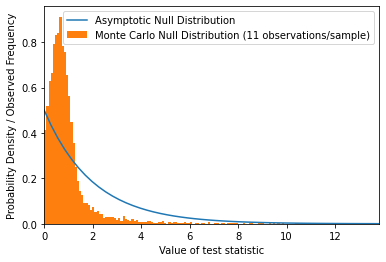

In [7]:
# Draw 10000 samples, each with 11 observations
n_observations = 11
n_samples = 10000
y = norm_dist.rvs(size=(n_observations, n_samples))

# calculate the value of the statistic for each sample
null_dist_mc = statistic(y)

# compare the MC and asymptotic distributions
plt.plot(y_grid, pdf)
plt.hist(null_dist_mc, density=True, bins=200)
plt.xlim(0, np.max(y_grid))
plt.xlabel("Value of test statistic")
plt.ylabel("Probability Density / Observed Frequency")
plt.legend(['Asymptotic Null Distribution', 'Monte Carlo Null Distribution (11 observations/sample)'])
plt.show()

This is because the asymptotic null distribution was derived under the assumption that the number of observations approaches infinity (hence the name "asymptotic" null distribution). Apparently, it is quite different from the null distribution of the test statistic when the number of observations is 11.

The true theoretical null distribution when the number of observations is 11 may not be possible to calculate analytically (in a way that can be expressed in terms of a finite number of common functions). So rather than comparing a test statistic against a theoretical null distribution to determine the $p$-value, the approach of the *Monte Carlo test* is to compare the test statistic against the Monte Carlo null distribution.

In [8]:
res = stats.jarque_bera(x)
stat, p_asymptotic = res
count = np.sum(null_dist_mc >= stat)
p_mc = count / n_samples
print(f"Asymptotic p-value {p_asymptotic}")
print(f"Monte Carlo p-value: {p_mc}")

Asymptotic p-value 0.03045746622458189
Monte Carlo p-value: 0.0085


These $p$-values are substantially different, so we might draw different conclusions about the validity of the null hypothesis depending on which test we perform. Under the 1% threshold used above, the Monte Carlo test would suggest that there is evidence for rejection of the null hypothesis whereas the asymptotic test performed by `stats.jarque_bera` would not. In other cases, the opposite may be true. In any case, it seems that the Monte Carlo test should be preferred when the number of observations is small.

`stats.monte_carlo_test` simplifies the process of performing a Monte Carlo test. All we need to provide is the obverved data, a function that generates data sampled under under the null hypothesis, and a function that computes the test statistic. `monte_carlo_test` returns an object with the observed statistic value, an empirical null distribution of the statistic, and the corresponding $p$-value.

In [9]:
res = stats.monte_carlo_test(sample=x, rvs=norm_dist.rvs, statistic=statistic, 
                             n_resamples=10000, alternative='greater')
print(f"Observed values of the statistic: {res.statistic}")
print(f"Monte Carlo p-value: {res.pvalue}")
print(f"Empirical null distribution shape: {res.null_distribution.shape}")

Observed values of the statistic: 6.982848237344646
Monte Carlo p-value: 0.0076
Empirical null distribution shape: (10000,)


Note that the $p$-value here is slightly different than `p_mc` above because the algorithm is stochastic. Nevertheless, `res.pvalue` is much closer to `p_mc` than to `p_asyptotic`: for small samples, the Monte Carlo null distribution generated from a sufficiently large number of random samples is often more accurate than the asymptotic null distribution, despite the error inherent in random sampling.

Here, we also passed optional arguments to control the behavior of `monte_carlo_test`. As one might expect, the parameter `n_resamples` controls the number of samples to draw from the provided *random variate sample* function. Perhaps less obvious is the meaning of `alternative`, which controls which *alternative hypothesis* we are testing, that is, which tail of the null distribution the observed statistic value should be compared against. In this case, we are assessing the null hypothesis that the sample was drawn from a normal population against the alternative that the sample is drawn from a population which tends to produce a *greater* value of the test statistic. Perhaps more intuitively, the argument `'greater'` corresponds with the sign of the comparison against the null distribution (i.e., `null_dist_emperical >= statistic(x)` from above). Another options for `alternative` is `'less'` (i.e., `null_dist_emperical <= statistic(x)`). In some cases, a `'two-sided'` alternative is desired, which is twice the minimum of the "one-sided" $p$-values. (More on the choice of this convention below.)

We can improve performance of `monte_carlo_test` by ensuring that our test statistic is "vectorized". That is, instead of requiring a one-dimensional sample array as input, the statistic should accept an $n$-dimensional array of samples in which each *axis-slice* (e.g. row, column) is a distinct sample. Our `statistic` function is already vectorized in some sense. Above, we wrote `null_dist_emperical = statistic(y)`, and `statistic` computed the statistic for each column of the two-dimensional `y`.

In [10]:
print(y.shape)  # 10000 samples, each with 11 observations
print(statistic(y).shape)  # statistic for each column of y

(11, 10000)
(10000,)


However, `monte_carlo_test` requires that the statistic function accept an `axis` argument to compute the statistic along *any* axis. Only minor modifications are required:

In [11]:
def statistic_vectorized(x, axis=0):
    # Calculates the Jarque-Bera Statistic
    # Compare against https://github.com/scipy/scipy/blob/4cf21e753cf937d1c6c2d2a0e372fbc1dbbeea81/scipy/stats/_stats_py.py#L1583-L1637
    n = x.shape[axis]
    mu = np.mean(x, axis=axis, keepdims=True)
    x = x - mu  # remove the mean from the data
    s = stats.skew(x, axis=axis)  # calculate the sample skewness
    k = stats.kurtosis(x, axis=axis)  # calculate the sample kurtosis
    statistic = n/6 * (s**2 + k**2/4)
    return statistic

np.testing.assert_allclose(statistic_vectorized(y, axis=0), statistic_vectorized(y.T, axis=1))

But `monte_carlo_test` becomes much faster:


In [12]:
# Before
%timeit -r1 -n1 stats.monte_carlo_test(sample=x, rvs=norm_dist.rvs, statistic=statistic, n_resamples=10000, alternative='greater')

7.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
# After
%timeit stats.monte_carlo_test(sample=x, rvs=norm_dist.rvs, statistic=statistic_vectorized, n_resamples=10000, alternative='greater', vectorized=True)

10.8 ms ± 583 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


When a statistical test is already implemented in SciPy (like `stats.jarque_bera`), it becomes even easier to perform a Monte Carlo version of the test. We simply need to "wrap" it in another function which only returns the test statistic rather than the full result object.

In [14]:
def statistic_scipy(x):
    # `jarque_bera` returns a result obeject
    res = stats.jarque_bera(x)  
    # Our wrapper returns only the statistic, as required by `monte_carlo_test`
    return res.statistic

res = stats.monte_carlo_test(sample=x, rvs=norm_dist.rvs, statistic=statistic_scipy, n_resamples=10000, alternative='greater')
res.pvalue

0.008

Of course, besides enabling more accurate tests for small sample sizes, `monte_carlo_test` makes it easy to perform hypothesis tests *not* implemented in SciPy. For instance, suppose we want to assess whether our data is distributed according to a [`rayleigh` distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rayleigh). Just as the "normal distribution" is really a *family* of distributions parameterized by mean and standard deviations, so `rayleigh` is a family of distributions rather than one specific distribution. In contrast with the normal distribution, however, there are no tests in SciPy specifically designed to determine whether a sample is drawn from a Rayleigh distribution. 

The closest options are tests like [`ks_1samp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_1samp.html) and [`cramervonmises`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cramervonmises.html), which can assess whether a sample is drawn from a *specific* distribution. If we want to use these tests to assess whether the sample is distributed according to *any* Rayleigh distribution, one approach is to fit a Rayleigh distribution to the data, and then apply `ks_1samp` and `cramervonmises` to test whether the data were drawn from the fitted Rayleigh distribution.

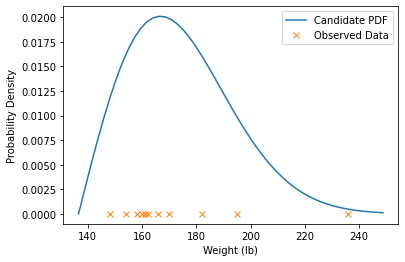

In [15]:
dist_family = stats.rayleigh
params = dist_family.fit(x)
dist_specific = dist_family(*params)

z = np.linspace(dist_specific.ppf(0), dist_specific.isf(0.001))
plt.plot(z, dist_specific.pdf(z))
plt.plot(x, np.zeros_like(x), 'x')
plt.legend(('Candidate PDF', 'Observed Data'))
plt.xlabel('Weight (lb)')
plt.ylabel('Probability Density')
plt.show()

To the eyes of the author, this does not look like a terrific fit. The mode of the Rayleigh distribution is too far to the right compared to cluster of observations around 160 lb. Also, according to this Rayleigh distribution, there is zero probability that any weights could be less than ~135 lb, which does not seem realistic. However, the `ks_1samp` and `cramervonmises` tests are both inconclusive, with relatively large $p$-values.

In [16]:
stats.ks_1samp(x, dist_specific.cdf)

KstestResult(statistic=0.26884627441317677, pvalue=0.3412228239139401)

In [17]:
stats.cramervonmises(x, dist_specific.cdf)

CramerVonMisesResult(statistic=0.17536330558707267, pvalue=0.32395064743536117)

A much more powerful test of the null hypothesis that the data is distributed according to *any* Rayleigh distribution is the [Anderson-Darling Test](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test). [`scipy.stats.anderson`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html) implements the test for some families of distributions, but not for the Rayleigh distribution. A simple implementation is included below.

In [18]:
def statistic(x):
    """Compute the Anderson-Darling statistic A^2"""
    # fit a distribution to the data
    params = dist_family.fit(x)
    dist = dist_family(*params)
    
    # compute A^2
    x = np.sort(x)
    n = len(x)
    i = np.arange(1, n+1)
    Si = (2*i - 1)/n * (dist.logcdf(x) + dist.logsf(x[::-1]))
    S = np.sum(Si)
    return -n - S

params = dist_family.fit(x)
dist = dist_family(*params)
res = stats.monte_carlo_test(x, rvs=dist.rvs, statistic=statistic, alternative='greater')
res.pvalue

0.0425042504250425

Although this does not meet the threshold for significance used above (1%), it does begin to cast doubt on the null hypothesis.

As we can see, `monte_carlo_test` is a versatile tool for comparing a sample against a distribution by means of an arbitrary statistic. Provided a statistic and null distribution, it can replicate the $p$-value of any such tests in SciPy, and it may be more accurate than these existing implementations, especially for small samples:

- [`skewtest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html)
- [`kurtosistest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosistest.html)
- [`normaltest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)
- [`shapiro`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
- [`anderson`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)
- [`chisquare`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html)
- [`power_divergence`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.power_divergence.html)
- [`cramervonmises`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cramervonmises.html)
- [`ks_1samp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_1samp.html)
- [`binomtest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binomtest.html)

In addition, `monte_carlo_test` can be used to perform tests not yet implemented in SciPy, such as [the Lilliefors Test](https://www.tandfonline.com/doi/abs/10.1080/01621459.1967.10482916) for normality.

However, there are other types of statistical tests that do not test whether a sample is drawn from a particular distribution or family of distributions, but instead test whether  multiple samples are drawn from the same distribution. For these situations, we turn our attention to `permutation_test`.